In [1]:
import cmocean as cmo
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
import pandas as pd
from scipy import signal
import warnings
warnings.filterwarnings('ignore')
from xmitgcm import open_mdsdataset
import seaborn as sns
import xarray as xr
#import palettes

In [3]:
# Load output
spec_febTS = xr.open_dataset('../curtain_SSH_spectra_febTS.nc')
X_spec = spec_febTS.X

ssh_febTS = xr.open_dataset('../curtain_SSH_SVB_febTS.nc')
ssh_febTS_NoB = xr.open_dataset('../curtain_SSH_NoSVB_febTS.nc')
X_ssh = ssh_febTS.X

ssh_febTS2 = xr.open_dataset('../curtain_SSH_SVB_febTS_2minOut.nc')
ssh_febTS_NoB2 = xr.open_dataset('../curtain_SSH_NoSVB_febTS_2minOut.nc')
X_ssh2 = ssh_febTS2.X

spec_baro = xr.open_dataset('../curtain_SSH_spectra_barotropic.nc')
X = spec_baro.X

ssh_baro = xr.open_dataset('../curtain_SSH_SVB_Barotropic.nc')
ssh_baro_NoB = xr.open_dataset('../curtain_SSH_NoSVB_Barotropic.nc')

In [4]:
# Get coastline points
df = pd.read_csv('../coastline_points_list.txt',names=['lon_ii','lat_jj'], header=1 )
lon_ii = np.array(df.lon_ii[:])-np.ones_like(df.lon_ii)
lat_jj = np.array(df.lat_jj[:])-np.ones_like(df.lat_jj)

In [5]:
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/01_SVB_febTS_output/'
outdir2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/01_noSVB_febTS/'
iters = [xx for xx in range(10,1440*5+10,10)]

levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels)
ds2 = open_mdsdataset(outdir2, prefix=['eta','dynVars'], levels=levels, iters=iters)

In [6]:
depth = ds2.Depth[:]
LAT = ds2['YC'][:]
LON = ds2['XC'][:]-360
lat = ds2.YC[:,0].data
lon = ds2.XC[0,:].data-360

Z = ds2['Z'][:]
Zl = ds2['Zl'][:]

# No bay centers mask
hFacC = ds2['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth,0)
mask_dep = np.ma.getmask(dep_masked)
time = np.arange(0,720)*600

# bay centers mask
# centers mask
depthSVB = ds.Depth[:]
hFacCSVB = ds['hFacC'][:]
hfacSVB = np.ma.masked_values(hFacCSVB, 0)
maskSVB = np.ma.getmask(hfacSVB)
dep_maskedSVB = np.ma.masked_values(depthSVB,0)
mask_depSVB = np.ma.getmask(dep_maskedSVB)

In [7]:
# Distance (haversine)
def distance(lat1,lon1,lat2,lon2):
    '''Distance using Haversine formula in km'''
    r = 6371 #radius of Earth (KM)
    p = np.pi/180  #Pi/180
    a = 0.5 - np.cos((lat2-lat1)*p)/2 + np.cos(lat1*p)*np.cos(lat2*p) * (1-np.cos((lon2-lon1)*p)) / 2
    d = 2 * r * np.arcsin(np.sqrt(a)) #2*R*asin In km
    return d

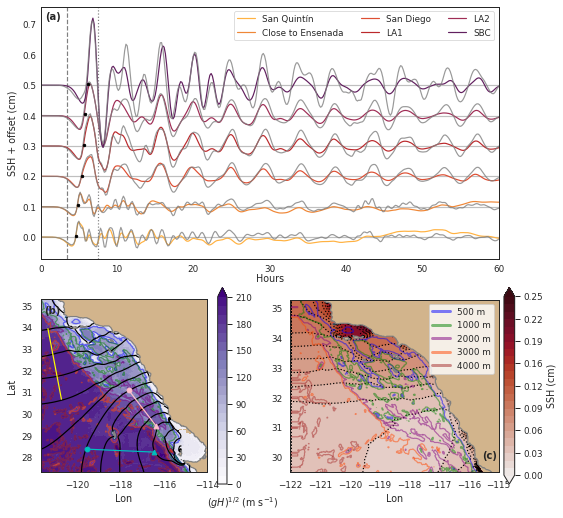

In [9]:
sns.set_context('paper')
sns.set_style('white')
times = np.arange(0,720)*600
time = np.arange(0,720)*120
colors=[ "#df7e66", "#94b594", "#224b5e","#b75347",]
colors2=("#ffd353", "#ffb242", "#ef8737", "#de4f33", "#bb292c", "#9f2d55", "#62205f", "#341648")

fig = plt.figure(figsize=(7.48,7.8))
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.05,bottom=0.5, top=0.95, wspace=0.05, hspace=0.4)
ax1 = plt.subplot(gs1[0,0])
offset=0

gs2 = gridspec.GridSpec(1, 2, width_ratios=[1,1], wspace=0.2)
gs2.update(left=0.05,bottom=0.1, top=0.45, hspace=0.05)
ax2 = plt.subplot(gs2[0,0])
ax3 = plt.subplot(gs2[0,1])

kk1 = 0
nt = 250 # end time index of the section where we look for zero-xing
n0 = 100
dx = 10
g = 9.81    
# ---- 1st node contours --------------
ax2.set_facecolor('tan')
ax2.set_xlabel('Lon')
ax2.set_ylabel('Lat')
ax2.set_xlim(238.3-360, 246-360)
ax2.set_ylim(27.3,35.3)
ax2.set_aspect(1)    

pc = ax2.contourf(LON,LAT,np.ma.masked_array(np.sqrt(depthSVB*g), mask=mask_depSVB),
                  22,
                  vmin=0, vmax=220, cmap='Purples', extend='max')
cb = plt.colorbar(pc,ax=ax2, extend='max')
ax2.text(1,-0.2, r'$(gH)^{1/2}$ (m s$^{-1}$)',transform=ax2.transAxes)

ax2.contour(LON,LAT,depthSVB[:,:],levels=[500,1000,2000,3000,4000],
            colors=['blue','green','purple','orangered','brown'], alpha=0.5)
ax2.contour(lon,lat,depthSVB[:,:], levels=[0], colors='0.5')

col = 'k'

##Before second node apears, contour ssh in the whole domain: 
for tt in range(23, 30):
    ssh = np.ma.masked_array(ds.ETAN[tt,:,:]-ds2.ETAN[tt,:,:], mask=mask[0,:,:])   
    ax2.contour(LON,LAT,ssh*100,levels=[0], alpha=1, colors=[col])

lati1 = 200
loni2 = 200
loni3 = 315
lati4 = 300

## Second node appears, only contour 1st node in some parts of the domain: 
for tt in range(30, 33):
    ssh = np.ma.masked_array(ds.ETAN[tt,lati1:,:]-ds2.ETAN[tt,lati1:,:], mask=mask[0,lati1:,:])   
    ax2.contour(LON[lati1:,:],LAT[lati1:,:],ssh*100,levels=[0], alpha=1, colors=[col])
    
    ssh = np.ma.masked_array(ds.ETAN[tt,:lati1,:loni2]-ds2.ETAN[tt,:lati1,:loni2], mask=mask[0,:lati1,:loni2])   
    ax2.contour(LON[:lati1,:loni2],LAT[:lati1,:loni2],ssh*100,levels=[0], alpha=1, colors=[col])
    
for tt in range(33,36):
    ssh = np.ma.masked_array(ds.ETAN[tt,lati4:,:loni3]-ds2.ETAN[tt,lati4:,:loni3], mask=mask[0,lati4:,:loni3])   
    ax2.contour(LON[lati4:,:loni3],LAT[lati4:,:loni3],ssh*100,levels=[0], alpha=1, colors=[col])
    
loni1 = 355
loni2 = 155
lati1 = 90
lati2 = 100

loni1b = 360
loni2b = 280
lati1b = 180
lati2b = 300

loni1c = 80
loni2c = 40
lati1c = 270
lati2c = 510

ax2.plot(lon[loni1], lat[lati1], 'c^')
ax2.plot(lon[loni2], lat[lati2], 'co')
ax2.plot([lon[loni2],lon[loni1]], [lat[lati2],lat[lati1]], 'c')

ax2.plot(lon[loni1b], lat[lati1b], '^', color='pink')
ax2.plot(lon[loni2b], lat[lati2b], 'o', color='pink')
ax2.plot([lon[loni2b],lon[loni1b]], [lat[lati2b],lat[lati1b]], color='pink')

ax2.plot([lon[loni2c],lon[loni1c]], [lat[lati2c],lat[lati1c]], color='yellow')

#dista = distance(lat[lati1],lon[loni1],lat[lati2],lon[loni2])
#distb = distance(lat[lati1b],lon[loni1b],lat[lati2b],lon[loni2b])
#distc = distance(lat[lati1c],lon[loni1c],lat[lati2c],lon[loni2c])


    
# ---- time series --------------
tt=45 # Threshold time for ax3
ax1.axvline(3.5, color='0.5', linestyle='--', alpha=1)
ax1.axvline(times[tt]/3600, color='0.5', linestyle=':', alpha=1)

for kk, lab, col in zip([47,100,230,307,335,440], 
                   ['San Quintín', 'Close to Ensenada','San Diego','LA1','LA2','SBC'], colors2[1:]):
    eta = 100*(ssh_febTS2.curtain_data[:,kk]-ssh_febTS_NoB2.curtain_data[:,kk])+offset
    eta2 = 100*(ssh_febTS.curtain_data[:,kk]-ssh_febTS_NoB.curtain_data[:,kk])+offset
    etab = 100*(ssh_baro.curtain_data[:,kk]-ssh_baro_NoB.curtain_data[:,kk])+offset
    ax1.axhline(offset, color='0.5', alpha=0.5)
    ax1.plot(ssh_febTS.T/3600,eta2, label=lab , alpha=1, color=col)
    ax1.plot(ssh_baro.T/3600,etab , alpha=0.8, color='0.5')
    
    eta2 = 100*(ssh_febTS2.curtain_data[n0:nt*5,kk]-ssh_febTS_NoB2.curtain_data[n0:nt*5,kk])+offset    
  
    for ssh, ii in zip(eta2,range(len(eta2))):
        if ssh-offset < 0:
            continue
        else:
            ax1.plot(ssh_febTS2.T[ii+n0]/3600,ssh, 'k.')
            break
            
    offset = offset + 0.1
     
ax1.set_xlim(0,24*2.5)
ax1.tick_params(axis='both', which='major', pad=0)  
ax1.legend(ncol=3)
ax1.set_ylabel('SSH + offset (cm)')
ax1.set_xlabel('Hours', labelpad=0)

# -------- Amplification plot ------------------
# Find max ssh before 7.2 hrs everywhere tt=43
ax3.set_facecolor('tan')
levels=np.linspace(0.0,0.25,25)
ssh = np.nanmax((ds.ETAN[:tt,:,:]-ds2.ETAN[:tt,:,:]),axis=0)   
pc = ax3.contourf(LON,LAT,np.ma.masked_array(ssh*100,mask=mask[0,:,:]),
                 levels=levels,
                 cmap=cmo.cm.amp, extend='both')
cbar_ax = fig.add_axes([0.91, 0.1, 0.02, 0.35]) 
plt.colorbar(pc,cax=cbar_ax, extend='both', label='SSH (cm)', format='%1.2f')
pc = ax3.contour(LON,LAT,np.ma.masked_array(ssh*100,mask=mask[0,:,:]),
                 levels=levels,
                 colors=['k'],alpha=1, linestyles=':')

ax3.contour(LON,LAT,depthSVB[:,:],levels=[500,1000,2000,3000,4000],
           colors=['blue','green','purple','orangered','brown'], alpha=0.5)
ax3.contour(lon,lat,depthSVB[:,:], levels=[0], colors='0.5')
ax3.set_xlim(238-360, 245-360)
ax3.set_ylim(29.5,35.3)
ax3.set_aspect(1)
#ax3.set_title('max ssh before %1.2f hrs' %(time[tt]/3600))
#ax3.set_ylabel('Lat')
ax3.set_xlabel('Lon')

custom_lines = [Line2D([0], [0], color='blue', lw=3, alpha=0.5),
                Line2D([0], [0], color='green', lw=3, alpha=0.5),
                Line2D([0], [0], color='purple', lw=3, alpha=0.5),
               Line2D([0], [0], color='orangered', lw=3, alpha=0.5), 
               Line2D([0], [0], color='brown', lw=3, alpha=0.5)]

ax3.legend(custom_lines, ['500 m', '1000 m', '2000 m','3000 m','4000 m'])

ax1.text(0.01,0.95,'(a)',fontweight='bold', fontsize=10, transform=ax1.transAxes)
ax2.text(0.02,0.92,'(b)',fontweight='bold', fontsize=10, transform=ax2.transAxes)
ax3.text(0.92,0.08,'(c)',fontweight='bold', fontsize=10, transform=ax3.transAxes)

plt.savefig('figure4_withDrag.png', dpi=300, bbox_inches='tight')

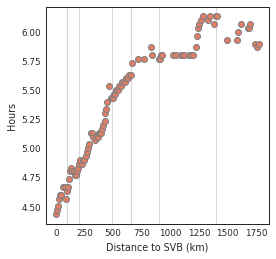

In [10]:
sns.set_context('paper')
sns.set_style('white')
times = np.arange(0,720)*600
time = np.arange(0,720)*120
colors=[ "#df7e66", "#94b594", "#224b5e","#b75347",]
colors2=("#ffd353", "#ffb242", "#ef8737", "#de4f33", "#bb292c", "#9f2d55", "#62205f", "#341648")

fig, ax2 = plt.subplots(1,1,figsize=(4,4))

offset=0

kk1 = 0
nt = 250 # end time index of the section where we look for zero-xing
n0 = 100
dx = 10

for kk, lab in zip([47,100,230,307,335,440], 
                   ['San Quintín','Close to Ensenada','San Diego','LA1','LA2','SBC']):
    ax2.axvline(ssh_febTS2.X[kk], color='0.7', alpha=0.5)
# ---- arrival(?) time of first zero-crossing --------------
zeroxing = np.empty(100)
zeroxing_baro = np.empty(100)
jj=0
for kk in range(0,500,5):  
    # uses 2 min output data
    eta = 100*(ssh_febTS2.curtain_data[n0:nt,kk]-ssh_febTS_NoB2.curtain_data[n0:nt,kk])
    for ssh, ii in zip(eta, range(len(eta))):
        if ssh < 0:
            continue
        else:
            zeroxing[jj] = ssh_febTS2.T[ii+n0]/3600
            break    
    jj=jj+1
    
ax2.plot(ssh_febTS.X[0:500:5],zeroxing,'o', label='base',
         markeredgecolor='0.5',color="#df7e66", markersize=6)
ax2.tick_params(axis='both', which='major', pad=0)  
ax2.set_ylabel('Hours')
ax2.set_xlabel('Distance to SVB (km)')
    
plt.savefig('S3.png', dpi=500, bbox_inches='tight')

In [10]:
print('%f' %np.max(depthSVB))

4700.000000


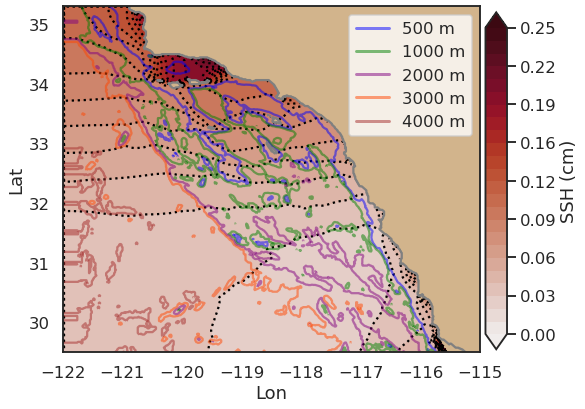

In [17]:
sns.set_context('talk')
sns.set_style('white')
times = np.arange(0,720)*600
time = np.arange(0,720)*120
colors=[ "#df7e66", "#94b594", "#224b5e","#b75347",]
colors2=("#ffd353", "#ffb242", "#ef8737", "#de4f33", "#bb292c", "#9f2d55", "#62205f", "#341648")

fig,ax1 = plt.subplots(1,1,figsize=(7.48,7.8))

kk1 = 0
nt = 250 # end time index of the section where we look for zero-xing
n0 = 100
dx = 10
g = 9.81    

# -------- Amplification plot ------------------
# Find max ssh before 7.2 hrs everywhere tt=43
ax1.set_facecolor('tan')
levels=np.linspace(0.0,0.25,25)
ssh = np.nanmax((ds.ETAN[:tt,:,:]-ds2.ETAN[:tt,:,:]),axis=0)   
pc = ax1.contourf(LON,LAT,np.ma.masked_array(ssh*100,mask=mask[0,:,:]),
                 levels=levels,
                 cmap=cmo.cm.amp, extend='both')
cbar_ax = fig.add_axes([0.91, 0.2, 0.04, 0.6]) 
plt.colorbar(pc,cax=cbar_ax, extend='both', label='SSH (cm)', format='%1.2f')
pc = ax1.contour(LON,LAT,np.ma.masked_array(ssh*100,mask=mask[0,:,:]),
                 levels=levels,
                 colors=['k'],alpha=1, linestyles=':')

ax1.contour(LON,LAT,depthSVB[:,:],levels=[500,1000,2000,3000,4000],
           colors=['blue','green','purple','orangered','brown'], alpha=0.5)
ax1.contour(lon,lat,depthSVB[:,:], levels=[0], colors='0.5')
ax1.set_xlim(238-360, 245-360)
ax1.set_ylim(29.5,35.3)
ax1.set_aspect(1)
#ax3.set_title('max ssh before %1.2f hrs' %(time[tt]/3600))
ax1.set_ylabel('Lat')
ax1.set_xlabel('Lon')

custom_lines = [Line2D([0], [0], color='blue', lw=3, alpha=0.5),
                Line2D([0], [0], color='green', lw=3, alpha=0.5),
                Line2D([0], [0], color='purple', lw=3, alpha=0.5),
               Line2D([0], [0], color='orangered', lw=3, alpha=0.5), 
               Line2D([0], [0], color='brown', lw=3, alpha=0.5)]

ax1.legend(custom_lines, ['500 m', '1000 m', '2000 m','3000 m','4000 m'])

plt.savefig('fig_amplification.png', dpi=300, bbox_inches='tight')